# PCL Detection using GPT-3 Model

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install openai

     |████████████████████████████████| 40 kB 3.2 MB/s 
     |████████████████████████████████| 161 kB 6.7 MB/s 
  Created wheel for openai: filename=openai-0.14.0-py3-none-any.whl size=49824 sha256=1ff29a896c837b748178c000675f3034a253d14607d46abc4d79259c511040a5
  Stored in directory: /root/.cache/pip/wheels/45/5f/9e/6035f88eb6fc313fd26ddb4d4b65bfb6fa02d7e5a124160fe9
Successfully built openai


In [ ]:
import os
import openai
import math

# Load your API key from an environment variable or secret management service
secret_key = 'enter_your_secret_key_here'
openai.api_key = secret_key

In [ ]:
!wget https://gist.githubusercontent.com/Sirwe-Saeedi/eff6f35a0aa182c2043da977e3a55171/raw/1865bd29a8a8c16580fec55f084316ed92d34950/TrainingSet_EvaluationPhase.csv

--2022-02-10 22:49:21--  https://gist.githubusercontent.com/Sirwe-Saeedi/eff6f35a0aa182c2043da977e3a55171/raw/1865bd29a8a8c16580fec55f084316ed92d34950/TrainingSet_EvaluationPhase.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3122842 (3.0M) [text/plain]
Saving to: ‘TrainingSet_EvaluationPhase.csv’

TrainingSet_Evaluat 100%[===================>]   2.98M  --.-KB/s    in 0.08s   

2022-02-10 22:49:22 (36.4 MB/s) - ‘TrainingSet_EvaluationPhase.csv’ saved [3122842/3122842]



In [ ]:
#Skip the disclaimer at the beginning of file
df_pcl = pd.read_csv('./TrainingSet_EvaluationPhase.csv', sep='\t', skiprows=4, header = None)
df_pcl.columns = ['index','paragraph_id',	'keyword', 'country_code',	'paragraph', 'label']
df_pcl.drop('index', axis = 1, inplace=True)
df_pcl

,paragraph_id,keyword,country_code,paragraph,label
0,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0
2,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0
3,@@7811231,disabled,nz,Council customers only signs would be displaye...,0
4,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0
...,...,...,...,...,...
10464,@@14297363,women,lk,Sri Lankan norms and culture inhibit women fro...,1
10465,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0
10466,@@20282330,in-need,ng,""" She has one huge platform , and information ...",3
10467,@@16753236,hopeless,in,""" Anja Ringgren Loven I ca n't find a word to ...",4


In [ ]:
def predict(df,file_, model_name = 'curie') :
  predictions = []
  for index, row in df.iterrows():
    res = openai.Classification.create(
        file=file_,
        query=row['text'],
        search_model=model_name, 
        model=model_name, 
        max_examples=3
    )
    best_score = -math.inf
    predicted_label = '0'
    i = 0
    for selected_example in res['selected_examples'] :
      score = float(res['selected_examples'][i]['score'])
      label = str(res['selected_examples'][i]['label'])

      if best_score < score :
        best_score = score
        predicted_label = label
    
    predictions.append(predicted_label)
    i += 1
  
  return predictions

In [ ]:
import sys
import json
def make_train_file(df,file_dir = 'train_binary.jsonl') :
  print('Writing the train.jsonl file...')

  original_stdout = sys.stdout # Save a reference to the original standard output

  with open(file_dir, 'w') as f:
      sys.stdout = f # Change the standard output to the file we created.
      for jdict in df.to_dict(orient='records'):
        print(json.dumps(jdict))
      sys.stdout = original_stdout # Reset the standard output to its original value

In [ ]:
def make_sample_dataframe(df,_n,_random_state = 119) :
  pcl_sample_test = pd.concat([df[df['label'] == 0].sample(n = _n,random_state = _random_state),
                        df[df['label'] == 1].sample(n = _n,random_state = _random_state)], axis = 0)
  pcl_sample_test = pcl_sample_test.drop(['paragraph_id','keyword','country_code'], axis = 1)
  pcl_sample_test = pcl_sample_test.set_axis(['text','label'], axis=1, inplace=False)
  pcl_sample_test['label'] = pcl_sample_test['label'].apply(str)
  pcl_sample_test.label = pcl_sample_test.label.astype(str)
  pcl_sample_test.text = pcl_sample_test.text.astype(str)

  # Shuffling the samples
  pcl_sample_test = pcl_sample_test.sample(frac=1,random_state = _random_state)
  return pcl_sample_test

# Binary Classification

## Curie Model

In [ ]:
df_binary = df_pcl
df_binary['label'] = df_binary['label'].replace({0 : 0, 1 : 1, 2 : 1, 3 : 1, 4 : 1})
df_binary['label'].value_counts()

0    8529
1    1940
Name: label, dtype: int64

In [ ]:
pcl_sample = make_sample_dataframe(df = df_binary, _n = 500, _random_state = 17)
pcl_sample

,text,label
6570,"Following that , Mr. Mair said the whole essen...",1
10421,The European Commission further announced an e...,0
8615,""" We want all poor families to earn enough and...",1
2357,He said the refugee problem is an internationa...,0
3726,"Last year , Obasanjo called Biafra agitators :...",1
...,...,...
4839,"Also in 2012 , a homeless man , Naeem Davis , ...",0
4576,"Miller , out since straining his left hamstrin...",0
5594,""" The guy from Rosengard a district of Malmo w...",0
5198,To be able to feel pain is a defence mechanism...,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


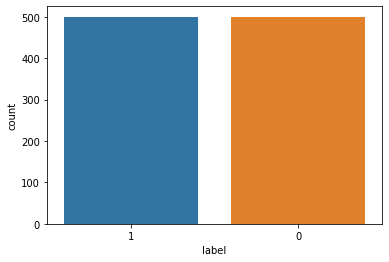

In [ ]:
import seaborn as sns
sns.countplot(pcl_sample['label'])

In [ ]:
make_train_file(pcl_sample,'train_binary.jsonl')

Writing the train.jsonl file...


In [ ]:
openai.File.create(file=open("/content/train_binary.jsonl"), purpose="classifications")

<File file id=file-fZ3iHtT1iKNPwVR7dGCG8kCT at 0x7febc6461dd0> JSON: {
  "bytes": 292394,
  "created_at": 1644518016,
  "filename": "train_binary.jsonl",
  "id": "file-fZ3iHtT1iKNPwVR7dGCG8kCT",
  "object": "file",
  "purpose": "classifications",
  "status": "uploaded",
  "status_details": null
}

In [ ]:
pcl_sample_test = make_sample_dataframe(df = df_binary, _n = 50, _random_state = 107)
pcl_sample_test

,text,label
6356,"Amnesty International said his sentence set "" ...",0
8887,Dr. Abdul-Hamid pointed out that thanks to the...,0
9015,"These were the "" Jews "" that came into power i...",0
3652,Ms Randall said it was essential that the Gove...,0
8599,B.C. housing minister Selina Robinson said tha...,1
...,...,...
6868,Immigration officials would have 90 days to de...,0
1410,Sheikh Hasina said she is happy of note that B...,1
5429,It is the government 's duty to ensure homeles...,1
6243,@TheTruth -You are already hopeless .,0


In [ ]:
predictions_curie = predict(pcl_sample_test,"file-fZ3iHtT1iKNPwVR7dGCG8kCT", model_name = 'curie')

In [ ]:
predictions_curie

['1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1',
 '0',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '1',
 '1',
 '0',
 '1']

In [ ]:
from sklearn.metrics import classification_report
y_true = pcl_sample_test['label'].to_list()
print(classification_report(y_true, predictions_curie))

              precision    recall  f1-score   support

           0       0.61      0.22      0.32        50
           1       0.52      0.86      0.65        50

    accuracy                           0.54       100
   macro avg       0.57      0.54      0.49       100
weighted avg       0.57      0.54      0.49       100



Text(0.5, 1.0, 'Confusion Matrix')

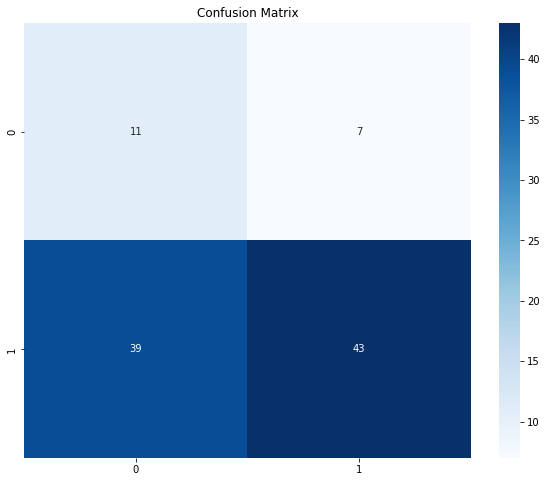

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
conf_mat = confusion_matrix(predictions_curie, y_true)
s1 = sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.title('Confusion Matrix')

In [ ]:
fig = s1.get_figure()
fig.savefig('Confusion_Matrix_Curie.pdf')  

## Davinci Model

In [ ]:
pcl_sample = make_sample_dataframe(df = df_binary, _n = 100, _random_state = 42)
pcl_sample

,text,label
9914,By continuing to use this site you consent to ...,0
7161,""" In a charged environment , a show like this ...",0
1663,""" The Impact of Climate Change in small commun...",0
7873,Hope Reins pairs rescued horses with kids in n...,1
660,The common thieves then stole a crust of bread...,1
...,...,...
9935,"Since its inception in 1994 , the NCVT has had...",1
10095,Another key focus is to provide healthcare for...,0
2163,"Analysts say that so-called "" chain migration ...",0
2576,"Later in 2008 , Avril Lavigne was awarded a Ce...",1


In [ ]:
make_train_file(pcl_sample,'train_binary_davinci.jsonl')

Writing the train.jsonl file...


In [ ]:
openai.File.create(file=open('train_binary_davinci.jsonl'), purpose="classifications")

<File file id=file-napbH51vETb8AfQfLCYtJJQ8 at 0x7febcf391b30> JSON: {
  "bytes": 60902,
  "created_at": 1644514990,
  "filename": "train_binary_davinci.jsonl",
  "id": "file-napbH51vETb8AfQfLCYtJJQ8",
  "object": "file",
  "purpose": "classifications",
  "status": "uploaded",
  "status_details": null
}

In [ ]:
pcl_sample_test = make_sample_dataframe(df = df_binary, _n = 50, _random_state = 13)
pcl_sample_test

,text,label
7119,"The notion of "" pilgrimage "" offers a power mo...",0
1999,It is encouraging to note that the poor famili...,1
153,When some people feel causing problem for some...,1
7518,The White Ferns celebrate victory over Austral...,0
3657,"Viet Thanh Nguyen 's new book , "" The Refugees...",0
...,...,...
10023,"After returning , migrants often face difficul...",0
826,Former director of Dhaka University 's Institu...,0
5856,"Migration , an issue that has vexed Germany si...",1
9678,""" The days when physically disabled persons we...",0


In [ ]:
len(list(set(pcl_sample_test.index) - set(pcl_sample.index)))

100

In [ ]:
predictions_davinci = predict(pcl_sample_test,"file-napbH51vETb8AfQfLCYtJJQ8", model_name = 'davinci')

In [ ]:
predictions_davinci

['0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1',
 '0',
 '1',
 '1',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '1',
 '1',
 '0',
 '1',
 '1']

In [ ]:
from sklearn.metrics import classification_report
y_true = pcl_sample_test['label'].to_list()
print(classification_report(y_true, predictions_curie))

              precision    recall  f1-score   support

           0       0.58      0.30      0.39        50
           1       0.53      0.78      0.63        50

    accuracy                           0.54       100
   macro avg       0.55      0.54      0.51       100
weighted avg       0.55      0.54      0.51       100



Text(0.5, 1.0, 'Confusion Matrix')

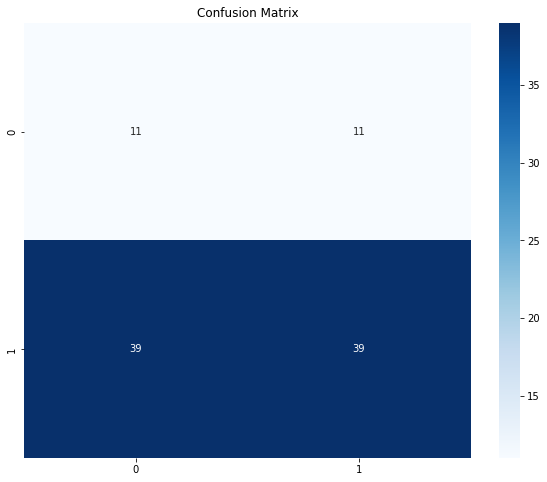

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
conf_mat = confusion_matrix(predictions_davinci, y_true)
s1 = sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.title('Confusion Matrix')

In [ ]:
fig = s1.get_figure()
fig.savefig('Confusion_Matrix_Davinci.pdf')  